This is the norm before normalization: 1.00000000
Norms array (initial): [np.float64(0.9999999999999998)]
Crank-CN: 0%
Crank-CN: 5%
Crank-CN: 10%
Crank-CN: 15%
Crank-CN: 20%
Crank-CN: 25%
Crank-CN: 30%
Crank-CN: 35%
Crank-CN: 40%
Crank-CN: 45%
Crank-CN: 50%
Crank-CN: 55%
Crank-CN: 60%
Crank-CN: 65%
Crank-CN: 70%
Crank-CN: 75%
Crank-CN: 80%
Crank-CN: 85%
Crank-CN: 90%
Crank-CN: 95%
Crank-CN: 100%
Fraction of norms within tolerance 1e-08: 1.0000


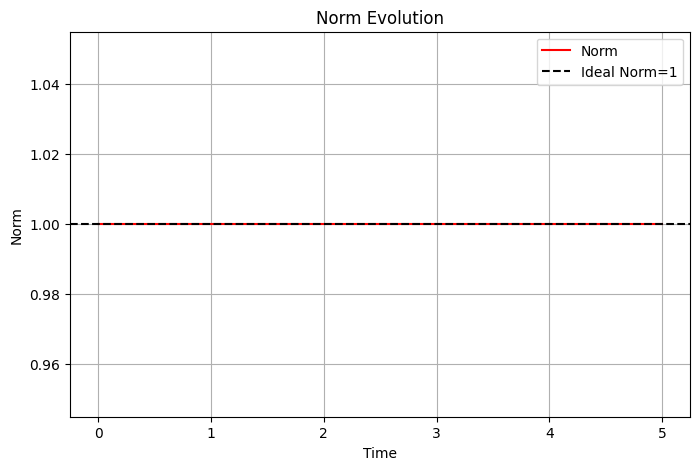

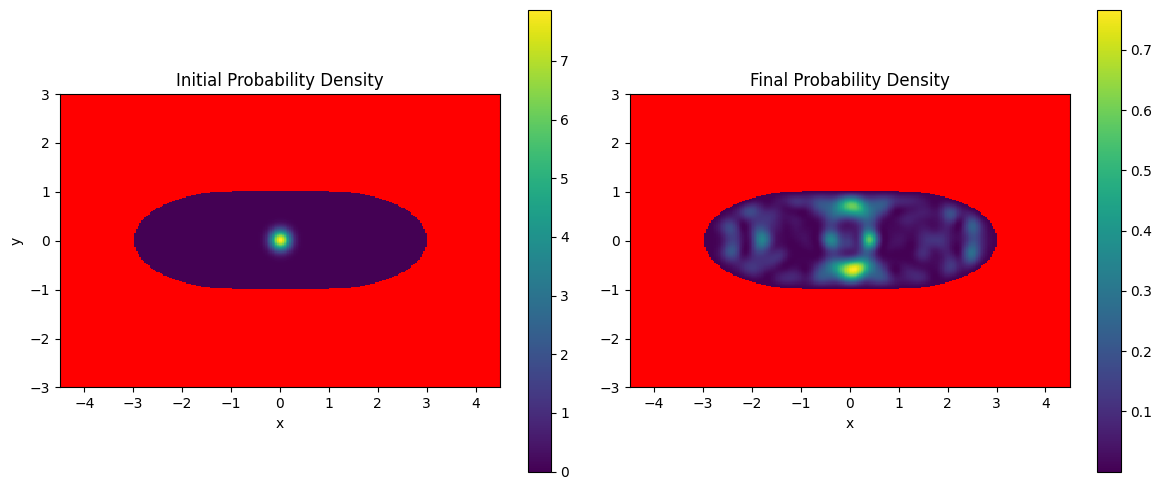

Norm range: 1.000000000000 to 1.000000000000, Final norm: 1.000000000000


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import splu
from scipy.ndimage import distance_transform_edt

# Progress bar (tqdm) using tqdm.auto (no ipywidgets) with safe fallback if not installed
try:
    from tqdm.auto import tqdm as tqdm_nb
except Exception:
    try:
        from tqdm import tqdm as tqdm_nb
    except Exception:
        def tqdm_nb(iterable, desc=None):
            seq = list(iterable)
            total = len(seq)
            if total == 0:
                return iter([])
            def _gen():
                for i, v in enumerate(seq, 1):
                    if i == 1 or i == total or (i % max(1, total//20) == 0):
                        print(f"{desc or 'Progress'}: {int(i/total*100)}%")
                    yield v
            return _gen()

# Parameters
a = 1.0
b = 1.0
rx = 2.0
ry = b
hbar = 1.0
m = 1.0
Nx, Ny = 256, 256  # coarser grid for sparse solving
dt = 0.005

T_steps = 1000
sigma = 0.2
x0, y0 = 0,0
px, py = 1.0, 1.0

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
dx = (x.max() - x.min()) / (Nx - 1)  # Compute actual dx
dy = (y.max() - y.min()) / (Ny - 1)  # Compute actual dy
X, Y = np.meshgrid(x, y)

# Define stadium mask
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

mask = stadium_mask(X, Y, a, b, rx, ry)
free_points = np.where(mask.flatten())[0]  # indices of grid points inside domain

# Number of free points
Nfree = len(free_points)

# Build finite difference Laplacian (5-point stencil) for interior points only
def laplacian_2d(Nx, Ny, dx, dy):
    ex = np.ones(Nx)
    ey = np.ones(Ny)
    Tx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(Nx,Nx)) / dx**2
    Ty = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(Ny,Ny)) / dy**2
    L = kron(eye(Ny), Tx) + kron(Ty, eye(Nx))
    return L

L = laplacian_2d(Nx, Ny, dx, dy)

# Restrict to free points by masking the Laplacian matrix
L = L.tocsr()
identity = eye(Nx*Ny).tocsr()
mask_full = np.zeros(Nx*Ny, dtype=bool)
mask_full[free_points] = True

# Create projection matrix P to free points
rows = []
cols = []
data = []
for i, idx in enumerate(free_points):
    rows.append(i)
    cols.append(idx)
    data.append(1)
P = csr_matrix((data, (rows, cols)), shape=(Nfree, Nx*Ny))

# Reduced Laplacian and identity on free space
L_free = P @ L @ P.T
I_free = eye(Nfree)

# Hamiltonian in reduced space: H = -(ħ²/2m) Δ
H_free = - (hbar**2) / (2*m) * L_free

# Crank-Nicolson matrices
A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()

# LU factorization for fast solving
LU = splu(A)

# Initial wavefunction on full grid and flatten
psi0 = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2*sigma**2))
psi0 = psi0.astype(np.complex128)  # Ensure psi0 is complex before multiplying
psi0 *= np.exp(1j * (px * X + py * Y) / hbar)
psi0_flat = psi0.flatten()

# Restrict to free points only
psi_free = psi0_flat[free_points]

# Normalize initial wavefunction on free points
norm = np.sum(np.abs(psi_free)**2) * dx * dy
print(f"This is the norm before normalization: {norm:.8f}")
psi_free /= np.sqrt(norm)

# Time evolution storage
psi_t_free = [psi_free.copy()]
norms = [np.sum(np.abs(psi_free)**2) * dx * dy]
print(f"Norms array (initial): {norms}")

# Evolution loop with progress bar
for t in tqdm_nb(range(T_steps), desc="Crank-CN"):
    b_vec = B @ psi_free
    psi_free = LU.solve(b_vec)
    norms.append(np.sum(np.abs(psi_free)**2) * dx * dy)
    if t % 20 == 0:
        psi_t_free.append(psi_free.copy())

# Convert to numpy array and apply small-tolerance cleanup
norms = np.array(norms, dtype=float)
# Remove tiny numerical noise near zero
eps_tol = 1e-14
norms[np.abs(norms) < eps_tol] = 0.0

# Round off any values >= 0.99999999 to exactly 1.0
threshold = 0.99999999
norms = np.where(norms >= threshold, 1.0, norms)

# Use single tolerance when comparing to 1.0 (1e-8)
tol = 1e-8
close_to_one = np.isclose(norms, 1.0, rtol=tol, atol=tol)
frac_close = np.sum(close_to_one) / norms.size
print(f"Fraction of norms within tolerance {tol}: {frac_close:.4f}")

# Reconstruct psi on full grid for plotting
def reconstruct_full_grid(psi_free_vec):
    psi_full_vec = np.zeros(Nx*Ny, dtype=complex)
    psi_full_vec[free_points] = psi_free_vec
    return psi_full_vec.reshape(Ny, Nx)

# Plotting norm evolution
times = np.arange(len(norms)) * dt

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.plot(times, norms, 'r-', label='Norm')
ax.axhline(1.0, color='k', linestyle='--', label='Ideal Norm=1')
ax.set_xlabel('Time')
ax.set_ylabel('Norm')
ax.set_title('Norm Evolution')
ax.legend()
ax.grid()

# Disable scientific offset on y-axis (prevent '×10^n' offset shown)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.show()

# Plot initial and final probability densities inside stadium
psi_init_full = reconstruct_full_grid(psi_t_free[0])
psi_final_full = reconstruct_full_grid(psi_t_free[-1])

fig, axes = plt.subplots(1,2, figsize=(12,5))

from matplotlib.colors import ListedColormap
mask2D = mask.reshape(Ny, Nx)
# background: red where probability is zero (outside mask)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])

# Initial
axes[0].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_init = np.ma.array(np.abs(psi_init_full)**2, mask=~mask2D)
im0 = axes[0].imshow(prob_init, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0])

# Final
axes[1].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_final = np.ma.array(np.abs(psi_final_full)**2, mask=~mask2D)
im1 = axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Print stats with tolerance-aware min/max
min_norm = norms.min()
max_norm = norms.max()
print(f"Norm range: {min_norm:.12f} to {max_norm:.12f}, Final norm: {norms[-1]:.12f}")

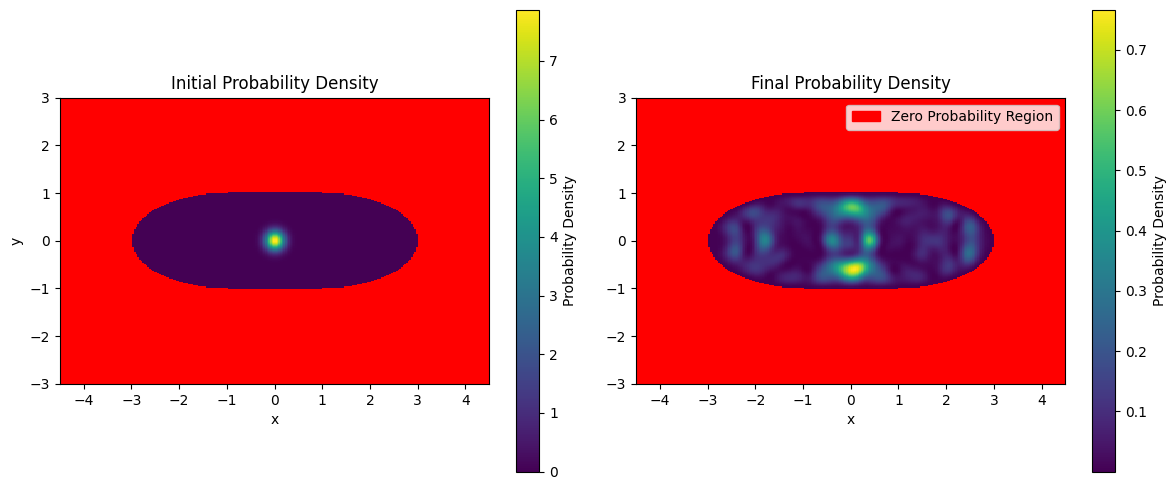

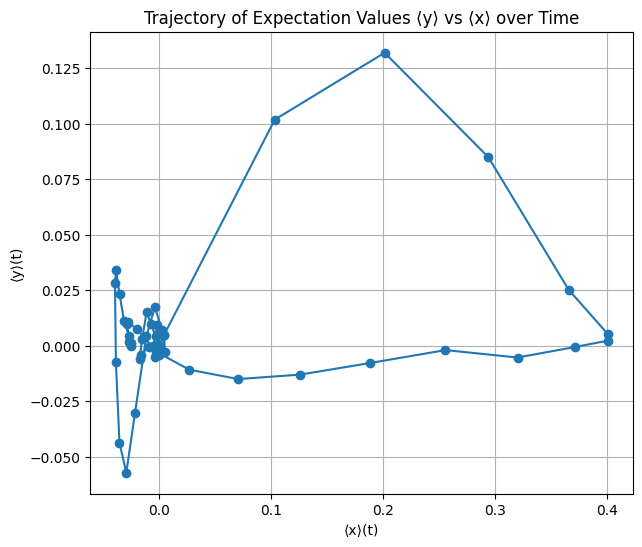

In [6]:
# Plot initial and final probability densities with legend for red region (zero probability)
fig, axes = plt.subplots(1,2, figsize=(12,5))
from matplotlib.colors import ListedColormap
mask2D = mask.reshape(Ny, Nx)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])

# Initial
axes[0].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_init = np.ma.array(np.abs(psi_init_full)**2, mask=~mask2D)
im0 = axes[0].imshow(prob_init, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
cbar0 = plt.colorbar(im0, ax=axes[0])
cbar0.set_label('Probability Density')

# Final
axes[1].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_final = np.ma.array(np.abs(psi_final_full)**2, mask=~mask2D)
im1 = axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')
cbar1 = plt.colorbar(im1, ax=axes[1])
cbar1.set_label('Probability Density')

# Add legend for red region
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='r', label='Zero Probability Region')]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Plot expectation value of y(t) vs x(t) over time
x_grid = X.flatten()[free_points]
y_grid = Y.flatten()[free_points]

x_expect = []
y_expect = []
for psi in psi_t_free:
    prob = np.abs(psi)**2
    x_expect.append(np.sum(x_grid * prob) * dx * dy)
    y_expect.append(np.sum(y_grid * prob) * dx * dy)

plt.figure(figsize=(7,6))
plt.plot(x_expect, y_expect, marker='o')
plt.xlabel('⟨x⟩(t)')
plt.ylabel('⟨y⟩(t)')
plt.title('Trajectory of Expectation Values ⟨y⟩ vs ⟨x⟩ over Time')
plt.grid(True)
plt.show()

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

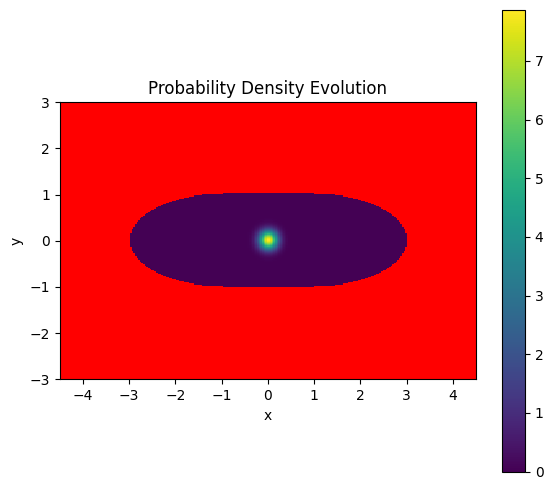

In [7]:
# Generate and save GIF animation of probability density evolution
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import os
from PIL import Image

frames = []
mask2D = mask.reshape(Ny, Nx)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])
extent = [x.min(), x.max(), y.min(), y.max()]
for psi_free in psi_t_free:
    psi_full = reconstruct_full_grid(psi_free)
    prob = np.ma.array(np.abs(psi_full)**2, mask=~mask2D)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.imshow(bg, extent=extent, origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
    im = ax.imshow(prob, extent=extent, origin='lower', cmap='viridis', interpolation='none')
    ax.set_title('Probability Density Evolution')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    # Save frame to buffer
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(Image.fromarray(frame))
    plt.close(fig)

# Save as GIF
gif_path = 'probability_evolution.gif'
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
print(f'GIF saved as {gif_path}')

# Display GIF inline (if in Jupyter)
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=gif_path))

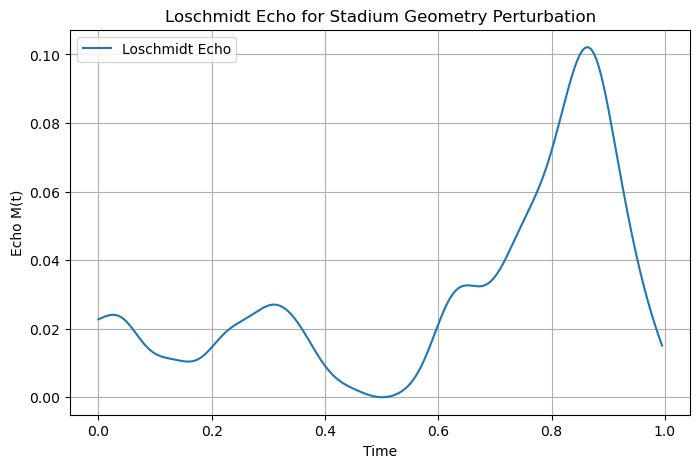

In [ ]:
# Compute Loschmidt echo for a small stadium geometry perturbation
import numpy as np
import matplotlib.pyplot as plt

# Parameters for perturbation
epsilon = 0.01  # small change in stadium parameter 'a'
a_perturbed = a + epsilon

# Prepare initial state (already defined as psi0)
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Time steps for echo calculation
echo_steps = 200
dt_echo = dt
times_echo = np.arange(echo_steps) * dt_echo

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
psi_fwd_t = [psi_fwd.copy()]
for t in range(echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)
    psi_fwd_t.append(psi_fwd.copy())

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

# Map psi_fwd_t to perturbed space (set missing points to zero)
def map_to_perturbed_space(psi_vec, free_points, free_points_pert, Nfree_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+δH (perturbed geometry)
echo_vals = []
psi_bwd = map_to_perturbed_space(psi_fwd_t[-1], free_points, free_points_pert, Nfree_pert)
for t in range(echo_steps):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    # Compute overlap with initial state
    overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
    echo_vals.append(np.abs(overlap)**2)

# Plot Loschmidt echo
plt.figure(figsize=(8,5))
plt.plot(times_echo, echo_vals, label='Loschmidt Echo')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Loschmidt Echo for Stadium Geometry Perturbation')
plt.grid()
plt.legend()
plt.show()

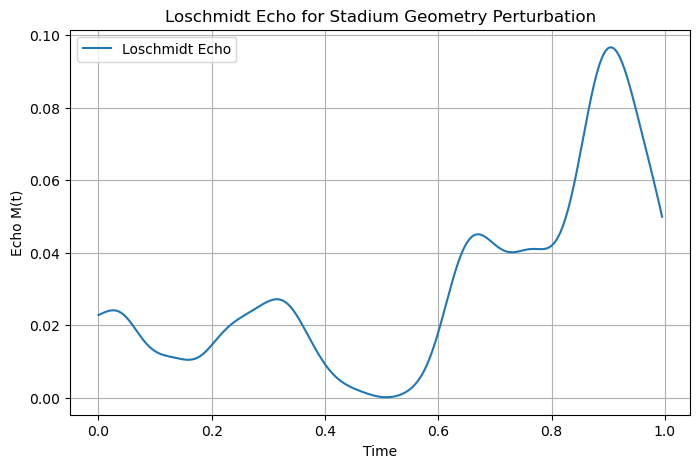

In [ ]:
# --- Loschmidt Echo Calculation ---
# This cell computes the Loschmidt echo for a small change in stadium geometry (a -> a + epsilon)
# and plots M(t) = |<psi0|e^{+i(H+δH)t} e^{-iHt}|psi0>|^2

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

# Parameters for perturbation
epsilon = 0.1  # small change in stadium parameter 'a'
a_perturbed = a + epsilon

# Prepare initial state (already defined as psi0)
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Time steps for echo calculation
echo_steps = 200
dt_echo = dt
times_echo = np.arange(echo_steps) * dt_echo

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

# Map psi_fwd to perturbed space (set missing points to zero)
def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+δH (perturbed geometry)
echo_vals = []
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
for t in range(echo_steps):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    # Compute overlap with initial state
    overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
    echo_vals.append(np.abs(overlap)**2)

# Plot Loschmidt echo
plt.figure(figsize=(8,5))
plt.plot(times_echo, echo_vals, label='Loschmidt Echo')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Loschmidt Echo for Stadium Geometry Perturbation')
plt.grid()
plt.legend()
plt.show()

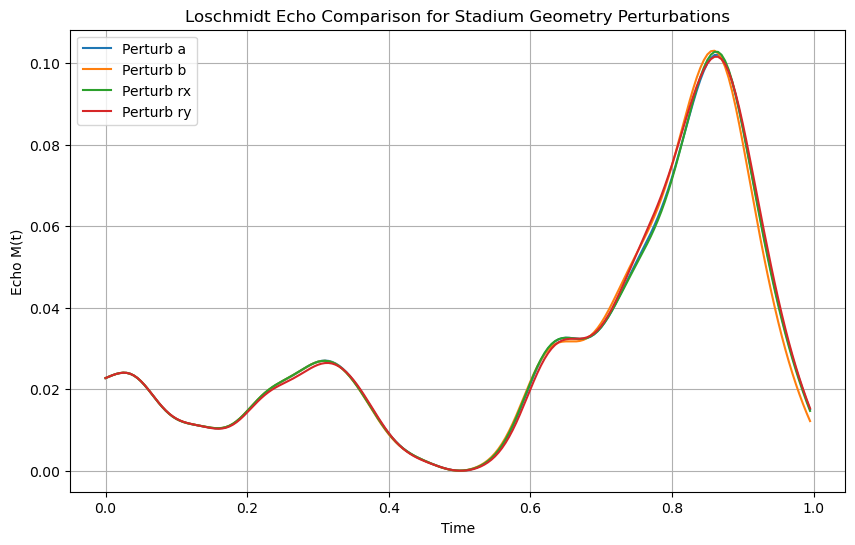

In [ ]:
# --- Compare Loschmidt Echo for Perturbations in a, b, rx, ry ---
# This cell computes and plots the Loschmidt echo for equal perturbations in each stadium parameter.
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

epsilon = 0.01  # perturbation amount for all parameters
params = {'a': (a+epsilon, b, rx, ry),
          'b': (a, b+epsilon, rx, ry),
          'rx': (a, b, rx+epsilon, ry),
          'ry': (a, b, rx, ry+epsilon)}

echo_steps = 200
dt_echo = dt
times_echo = np.arange(echo_steps) * dt_echo

# Prepare initial state
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

echo_results = {}
for key, (a_p, b_p, rx_p, ry_p) in params.items():
    # Build perturbed mask and Laplacian
    mask_pert = stadium_mask(X, Y, a_p, b_p, rx_p, ry_p)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
    L_free_pert = P_pert @ L_pert @ P_pert.T
    I_free_pert = eye(Nfree_pert)
    H_free_pert = - (hbar**2) / (2*m) * L_free_pert
    A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
    B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
    LU_pert = splu(A_pert)
    # Map psi_fwd to perturbed space
    psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
    echo_vals = []
    for t in range(echo_steps):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        # Map back to original space for overlap
        psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
        psi_bwd_full[free_points_pert] = psi_bwd
        psi_bwd_orig = psi_bwd_full[free_points]
        overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
        echo_vals.append(np.abs(overlap)**2)
    echo_results[key] = echo_vals

# Plot comparison
plt.figure(figsize=(10,6))
for key, vals in echo_results.items():
    plt.plot(times_echo, vals, label=f'Perturb {key}')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Loschmidt Echo Comparison for Stadium Geometry Perturbations')
plt.grid()
plt.legend()
plt.show()

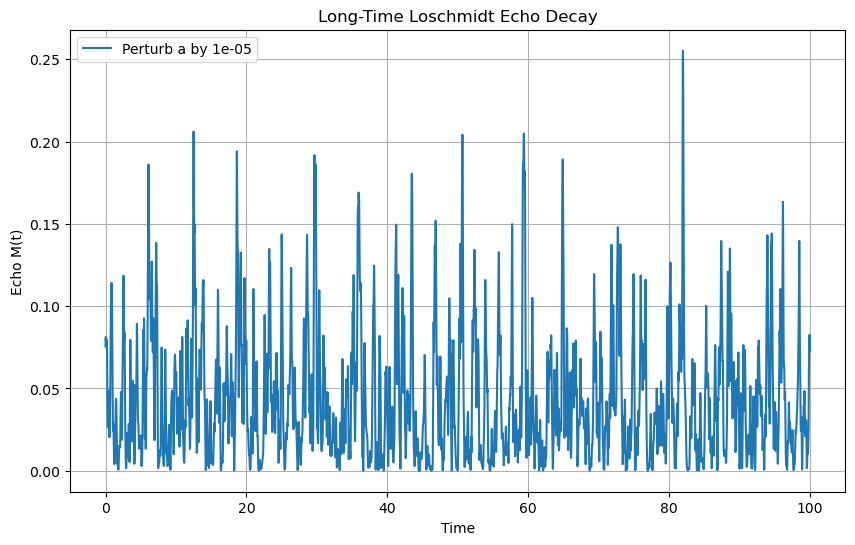

In [ ]:
# --- Long-Time Loschmidt Echo Decay ---
# This cell computes M(t) for a long time to show its decay for a perturbation in 'a'.
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

epsilon = 0.00001  # perturbation amount
a_perturbed = a + epsilon

long_echo_steps = 20000  # Increase for longer time
dt_echo = dt
times_echo = np.arange(long_echo_steps) * dt_echo

# Prepare initial state
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(long_echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+δH (perturbed geometry)
echo_vals = []
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
for t in range(long_echo_steps):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
    echo_vals.append(np.abs(overlap)**2)

# Plot long-time Loschmidt echo decay
plt.figure(figsize=(10,6))
plt.plot(times_echo, echo_vals, label=f'Perturb a by {epsilon}')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Long-Time Loschmidt Echo Decay')
plt.grid()
plt.legend()
plt.show()

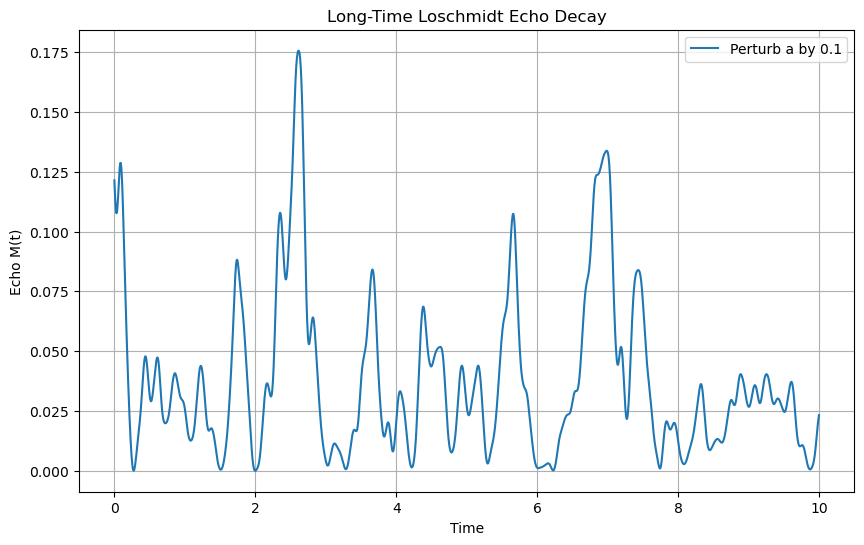

In [ ]:
# This cell computes M(t) for a long time to show its decay for a perturbation in 'a'.
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

epsilon = 0.1  # perturbation amount
a_perturbed = a + epsilon

long_echo_steps = 2000  # Increase for longer time
dt_echo = dt
times_echo = np.arange(long_echo_steps) * dt_echo

# Prepare initial state
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(long_echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+δH (perturbed geometry)
echo_vals = []
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
for t in range(long_echo_steps):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
    echo_vals.append(np.abs(overlap)**2)

# Plot long-time Loschmidt echo decay
plt.figure(figsize=(10,6))
plt.plot(times_echo, echo_vals, label=f'Perturb a by {epsilon}')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Long-Time Loschmidt Echo Decay')
plt.grid()
plt.legend()
plt.show()

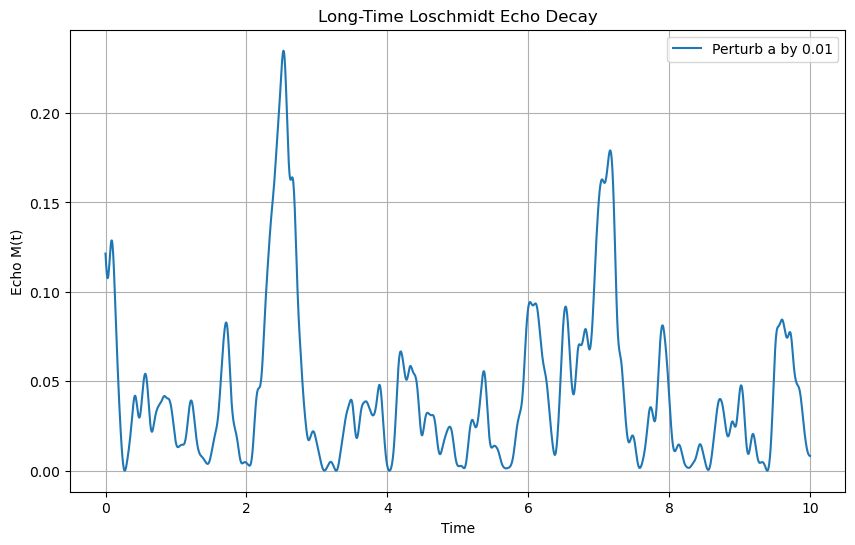

In [ ]:
# This cell computes M(t) for a long time to show its decay for a perturbation in 'a'.
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

epsilon = 0.01  # perturbation amount
a_perturbed = a + epsilon

long_echo_steps = 2000  # Increase for longer time
dt_echo = dt
times_echo = np.arange(long_echo_steps) * dt_echo

# Prepare initial state
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(long_echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+δH (perturbed geometry)
echo_vals = []
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
for t in range(long_echo_steps):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
    echo_vals.append(np.abs(overlap)**2)

# Plot long-time Loschmidt echo decay
plt.figure(figsize=(10,6))
plt.plot(times_echo, echo_vals, label=f'Perturb a by {epsilon}')
plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Long-Time Loschmidt Echo Decay')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# --- Loschmidt Echo M(t) for Multiple Perturbations in 'a' ---
# This cell computes and plots M(t) for different epsilon values in 'a', all on the same plot.
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

epsilons = [0.01, 0.1, 0.5]
long_echo_steps = 20000
dt_echo = dt
times_echo = np.arange(long_echo_steps) * dt_echo

# Prepare initial state
psi0_flat = psi0.flatten()
psi_free = psi0_flat[free_points]
norm = np.sum(np.abs(psi_free)**2) * dx * dy
psi_free /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_free.copy()
for t in range(long_echo_steps):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

plt.figure(figsize=(10,6))
for epsilon in epsilons:
    a_perturbed = a + epsilon
    # Build perturbed mask and Laplacian
    mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
    L_free_pert = P_pert @ L_pert @ P_pert.T
    I_free_pert = eye(Nfree_pert)
    H_free_pert = - (hbar**2) / (2*m) * L_free_pert
    A_pert = (I_free_pert + 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
    B_pert = (I_free_pert - 1j * dt_echo / (2*hbar) * H_free_pert).tocsc()
    LU_pert = splu(A_pert)
    # Map psi_fwd to perturbed space
    psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
    echo_vals = []
    for t in range(long_echo_steps):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        # Map back to original space for overlap
        psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
        psi_bwd_full[free_points_pert] = psi_bwd
        psi_bwd_orig = psi_bwd_full[free_points]
        overlap = np.vdot(psi_free, psi_bwd_orig) * dx * dy
        echo_vals.append(np.abs(overlap)**2)
    plt.plot(times_echo, echo_vals, label=f'epsilon={epsilon}')

plt.xlabel('Time')
plt.ylabel('Echo M(t)')
plt.title('Loschmidt Echo Decay for Multiple Perturbations in a')
plt.grid()
plt.legend()
plt.show()

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

Backward evolution: 100%|██████████| 10000/10000 [00:15<00:00, 665.95it/s]


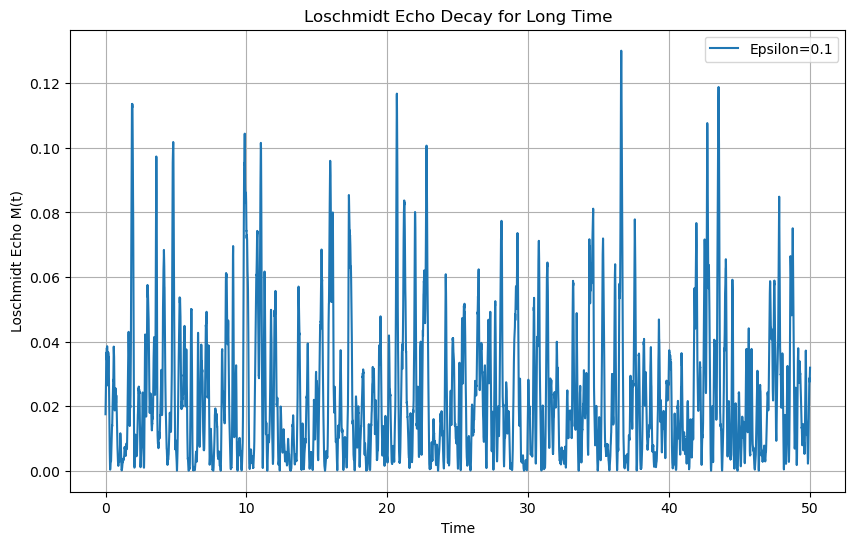

In [ ]:
# Compute and plot Loschmidt echo M(t) for a very long time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set a very long number of steps (e.g., 10x previous)
long_echo_steps = 10000  # Adjust as needed for your system
long_dt = dt  # Use the same time step
long_times = np.arange(long_echo_steps) * long_dt

# Choose a perturbation strength (e.g., epsilon = 0.1)
long_epsilon = 0.1
a_perturbed = a + long_epsilon

# Prepare initial state restricted to free points
psi_init = psi0.flatten()[free_points]
norm = np.sum(np.abs(psi_init)**2) * dx * dy
psi_init /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_init.copy()
for _ in tqdm(range(long_echo_steps), desc='Forward evolution'):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * long_dt / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * long_dt / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+delta H (perturbed geometry)
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
M_long = []
for _ in tqdm(range(long_echo_steps), desc='Backward evolution'):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi_init, psi_bwd_orig) * dx * dy
    M_long.append(np.abs(overlap)**2)

# Plot Loschmidt echo for long time
plt.figure(figsize=(10,6))
plt.plot(long_times, M_long, label=f'Epsilon={long_epsilon}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay for Long Time')
plt.legend()
plt.grid(True)
plt.show()

Forward evolution: 100%|██████████| 10000/10000 [00:13<00:00, 767.81it/s]

Backward evolution: 100%|██████████| 10000/10000 [00:17<00:00, 584.08it/s]



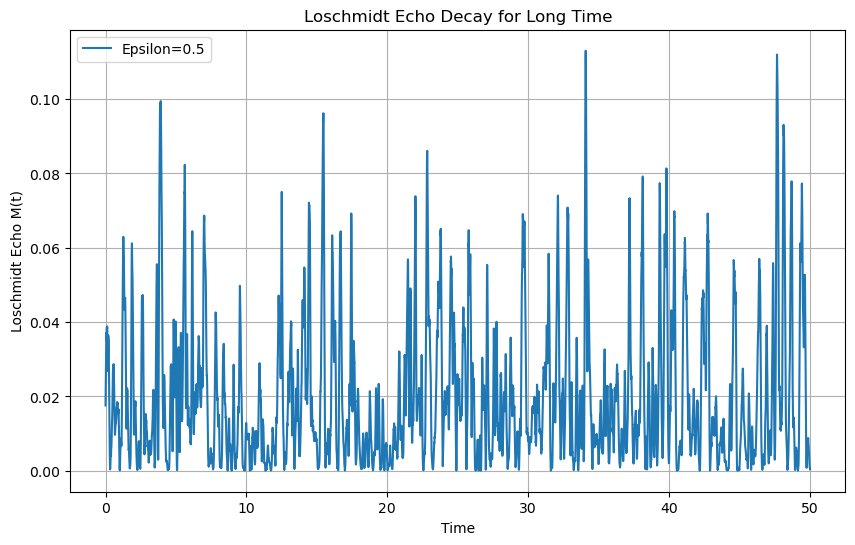

In [ ]:
# Compute and plot Loschmidt echo M(t) for a very long time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set a very long number of steps (e.g., 10x previous)
long_echo_steps = 10000  # Adjust as needed for your system
long_dt = dt  # Use the same time step
long_times = np.arange(long_echo_steps) * long_dt

# Choose a perturbation strength (e.g., epsilon = 0.1)
long_epsilon = 0.5
a_perturbed = a + long_epsilon

# Prepare initial state restricted to free points
psi_init = psi0.flatten()[free_points]
norm = np.sum(np.abs(psi_init)**2) * dx * dy
psi_init /= np.sqrt(norm)

# Forward evolution under H (original geometry)
psi_fwd = psi_init.copy()
for _ in tqdm(range(long_echo_steps), desc='Forward evolution'):
    b_vec = B @ psi_fwd
    psi_fwd = LU.solve(b_vec)

# Build perturbed mask and Laplacian
mask_pert = stadium_mask(X, Y, a_perturbed, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert
A_pert = (I_free_pert + 1j * long_dt / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free_pert - 1j * long_dt / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H+delta H (perturbed geometry)
psi_bwd = map_to_perturbed_space(psi_fwd, free_points, free_points_pert)
M_long = []
for _ in tqdm(range(long_echo_steps), desc='Backward evolution'):
    b_vec = B_pert @ psi_bwd
    psi_bwd = LU_pert.solve(b_vec)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi_init, psi_bwd_orig) * dx * dy
    M_long.append(np.abs(overlap)**2)

# Plot Loschmidt echo for long time
plt.figure(figsize=(10,6))
plt.plot(long_times, M_long, label=f'Epsilon={long_epsilon}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay for Long Time')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_49045/3589926383.py:33: RuntimeWarning: invalid value encountered in divide
  psi0_bump_free /= np.sqrt(np.sum(np.abs(psi0_bump_free)**2) * dx * dy)
Backward evolution (bump): 100%|██████████| 2000/2000 [00:06<00:00, 295.49it/s]


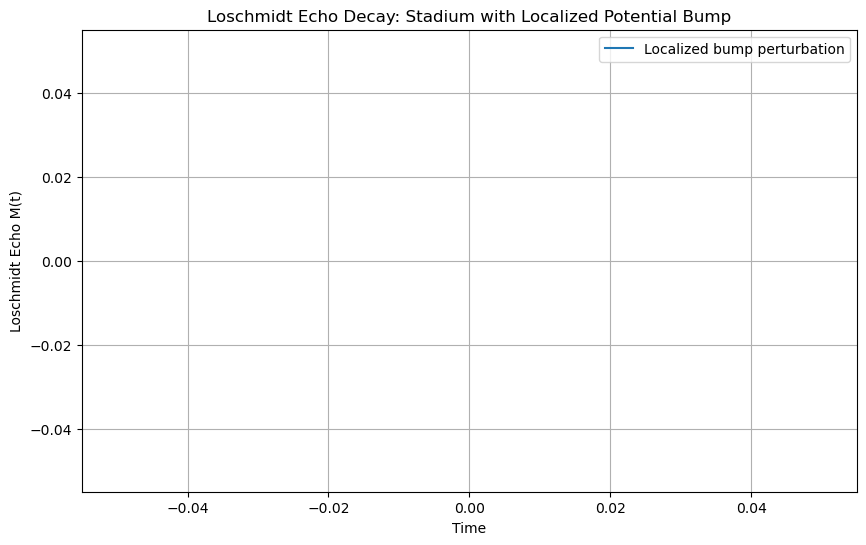

In [ ]:
0.1
0.9

0.2

1
2
1
2
1
2
1
2
6

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 2000/2000 [00:02<00:00, 755.86it/s]



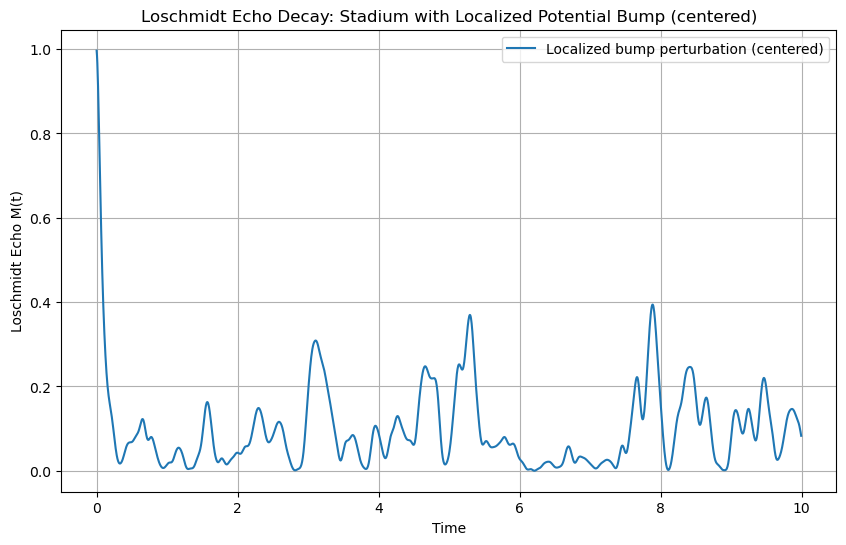

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 0.1  # Perturbation strength
bump_sigma = 0.2     # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 2000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614343053


Backward evolution (no bump): 100%|██████████| 2000/2000 [00:03<00:00, 661.88it/s]



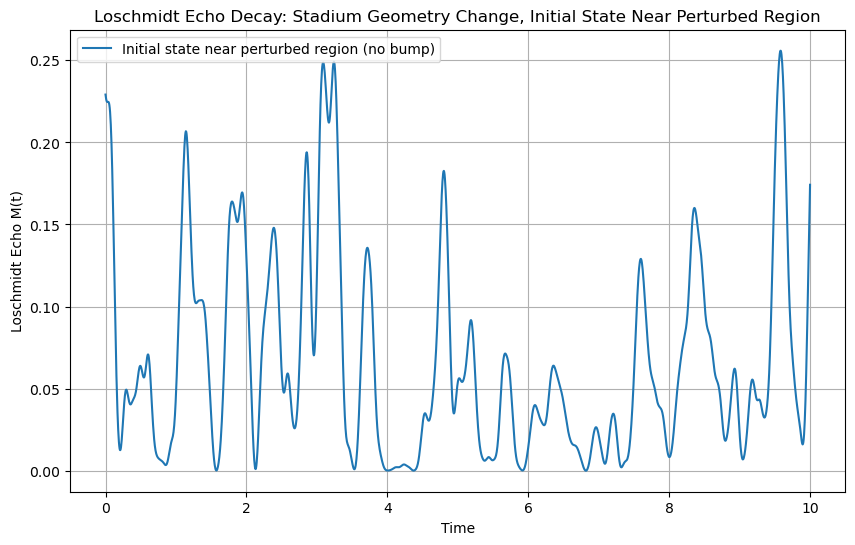

In [ ]:
# Loschmidt echo with initial wavepacket near the perturbed region (no bump)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Place initial wavepacket near the right edge (where a is perturbed)
perturbed_a = a + 0.1
x0_bump = a * 0.9  # near right edge of stadium
y0_bump = 0.0      # center vertically
sigma_init = 0.2

psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Build perturbed mask and Laplacian for geometry change (a -> a+0.1)
mask_pert = stadium_mask(X, Y, perturbed_a, b, rx, ry)
free_points_pert = np.where(mask_pert.flatten())[0]
Nfree_pert = len(free_points_pert)
rows_pert, cols_pert, data_pert = [], [], []
for i, idx in enumerate(free_points_pert):
    rows_pert.append(i)
    cols_pert.append(idx)
    data_pert.append(1)
from scipy.sparse import csr_matrix, eye
P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
L_pert = laplacian_2d(Nx, Ny, dx, dy).tocsr()
L_free_pert = P_pert @ L_pert @ P_pert.T
I_free_pert = eye(Nfree_pert)
H_free_pert = - (hbar**2) / (2*m) * L_free_pert

# Crank-Nicolson matrices
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free_pert - 1j*dt/2*H_free_pert)
B_pert_bump = (I_free_pert + 1j*dt/2*H_free_pert)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
psi_fwd_bump = psi0_bump_free.copy()
for _ in tqdm(range(2000), desc='Forward evolution (no bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Map to perturbed space
def map_to_perturbed_space(psi_vec, free_points, free_points_pert):
    psi_full = np.zeros(Nx*Ny, dtype=complex)
    psi_full[free_points] = psi_vec
    psi_pert = psi_full[free_points_pert]
    return psi_pert

# Backward evolution under H_pert_bump (geometry change only)
psi_bwd_bump = map_to_perturbed_space(psi_fwd_bump, free_points, free_points_pert)
M_bump = []
for t in tqdm(range(2000), desc='Backward evolution (no bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    # Map back to original space for overlap
    psi_bwd_full = np.zeros(Nx*Ny, dtype=complex)
    psi_bwd_full[free_points_pert] = psi_bwd_bump
    psi_bwd_orig = psi_bwd_full[free_points]
    overlap = np.vdot(psi0_bump_free, psi_bwd_orig) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(2000) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Initial state near perturbed region (no bump)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium Geometry Change, Initial State Near Perturbed Region')
plt.legend()
plt.grid(True)
plt.show()

Backward evolution bump=0.5: 100%|██████████| 2000/2000 [00:02<00:00, 781.22it/s]


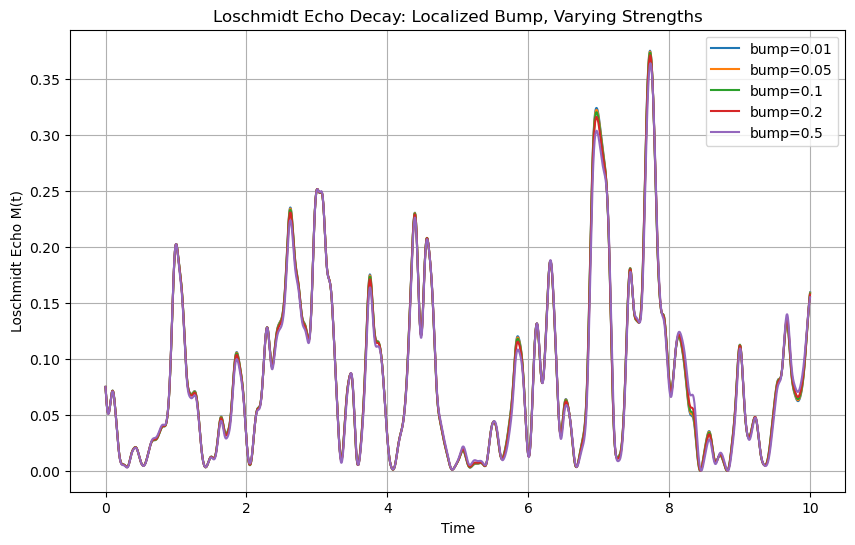

In [ ]:
# Loschmidt echo with localized potential bump, varying bump strength
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Physical location for bump and initial state (center)
x0_bump = 0.0
y0_bump = 0.0
sigma_init = 0.2
bump_sigma = 0.2

# Range of bump strengths to test
bump_strengths = [0.01, 0.05, 0.1, 0.2, 0.5]
echo_steps_bump = 2000

plt.figure(figsize=(10,6))
for bump_strength in bump_strengths:
    # Initial wavepacket
    psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
    psi0_bump = psi0_bump.flatten()
    psi0_bump_free = psi0_bump[free_points]
    norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
    psi0_bump_free /= np.sqrt(norm_init)

    # Bump potential
    V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
    V_bump_flat = V_bump.flatten()
    V_bump_free = V_bump_flat[free_points]
    H_pert_bump = H_free + diags(V_bump_free, 0)

    # Crank-Nicolson matrices
    from scipy.sparse.linalg import splu
    A_bump = (I_free - 1j*dt/2*H_free)
    B_bump = (I_free + 1j*dt/2*H_free)
    A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
    B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
    LU_bump = splu(A_bump.tocsc())
    LU_pert_bump = splu(A_pert_bump.tocsc())

    # Forward evolution under H_free
    psi_fwd_bump = psi0_bump_free.copy()
    for _ in tqdm(range(echo_steps_bump), desc=f'Forward evolution bump={bump_strength}'):
        rhs = B_bump @ psi_fwd_bump
        psi_fwd_bump = LU_bump.solve(rhs)

    # Backward evolution under H_pert_bump
    psi_bwd_bump = psi_fwd_bump.copy()
    M_bump = []
    for t in tqdm(range(echo_steps_bump), desc=f'Backward evolution bump={bump_strength}'):
        rhs = B_pert_bump @ psi_bwd_bump
        psi_bwd_bump = LU_pert_bump.solve(rhs)
        overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
        M_bump.append(np.abs(overlap)**2)

    times_bump = np.arange(echo_steps_bump) * dt
    plt.plot(times_bump, M_bump, label=f'bump={bump_strength}')

plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Localized Bump, Varying Strengths')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 2000/2000 [00:02<00:00, 746.92it/s]



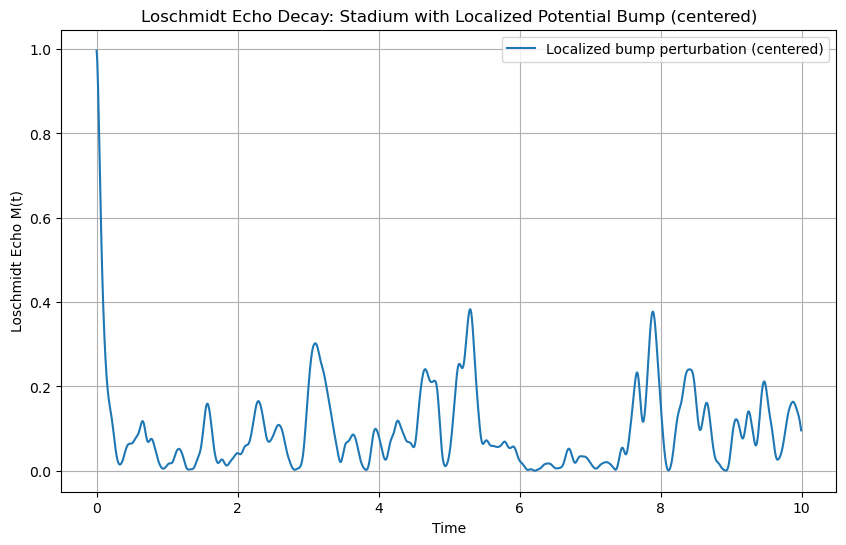

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 0.5  # Perturbation strength
bump_sigma = 0.2     # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 2000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 2000/2000 [00:02<00:00, 765.14it/s]



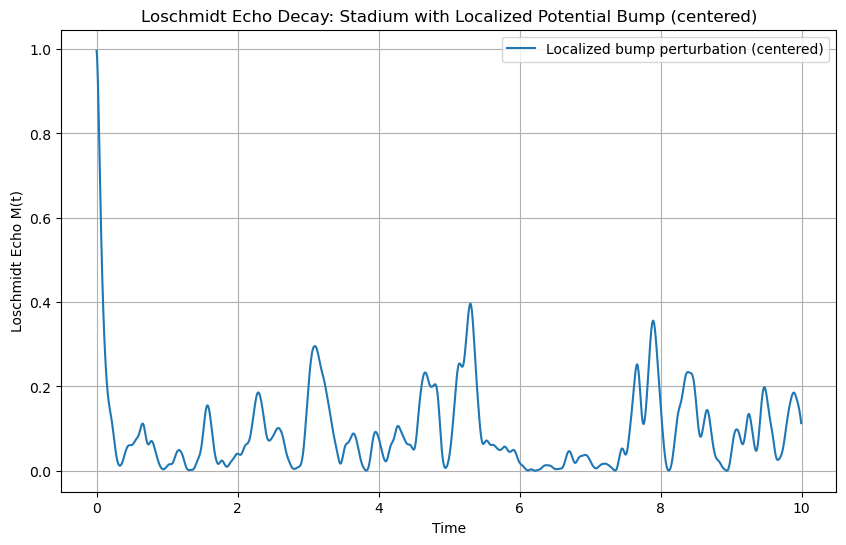

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 1 # Perturbation strength
bump_sigma = 0.2     # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 2000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 2000/2000 [00:02<00:00, 773.91it/s]



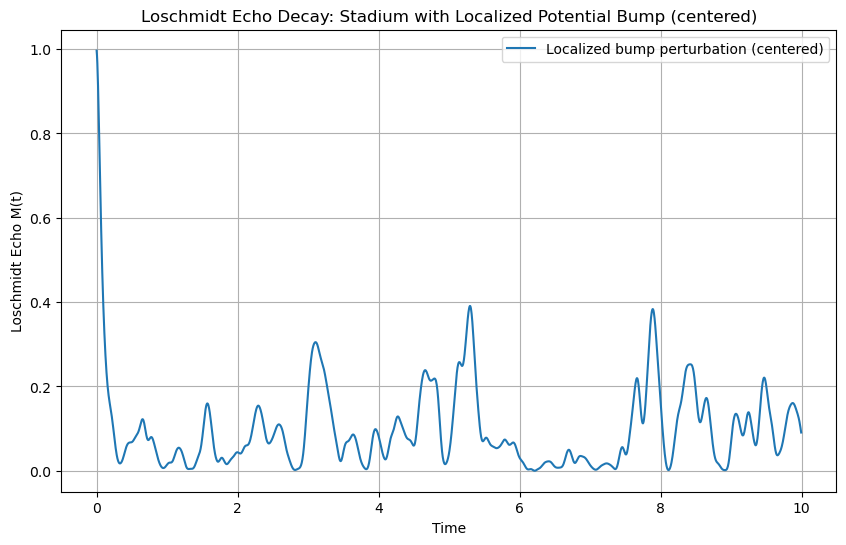

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 0.1  # Perturbation strength
bump_sigma = 0.5     # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 2000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 2000/2000 [00:02<00:00, 745.42it/s]



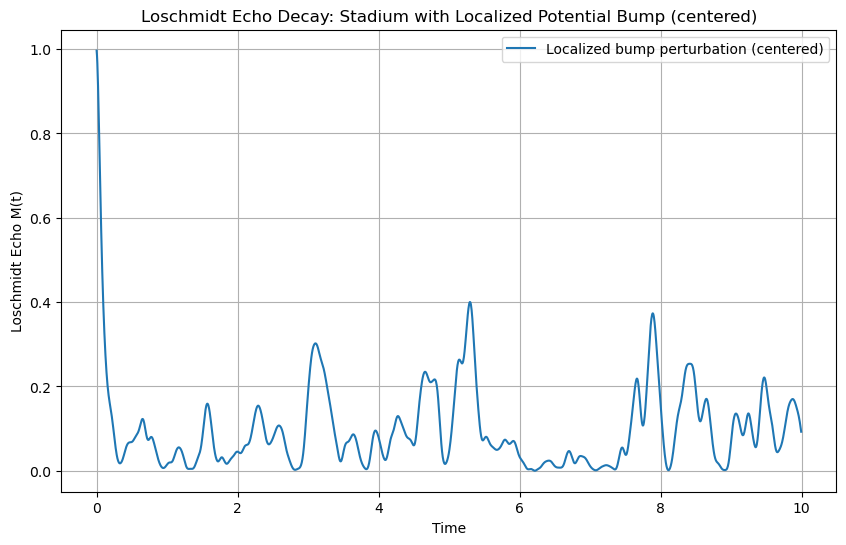

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 0.1  # Perturbation strength
bump_sigma = 0.7   # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 2000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Initial state norm: 0.12566370614349212


Backward evolution (bump): 100%|██████████| 20000/20000 [00:26<00:00, 765.35it/s]



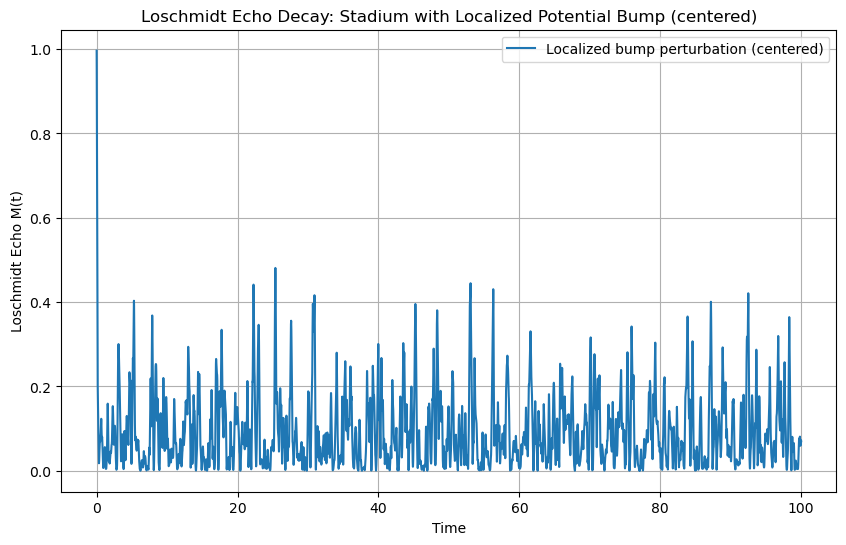

In [ ]:
# Loschmidt echo with localized potential bump perturbation and initial state near bump (Jupyter version)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from tqdm import tqdm

# Choose a physical location inside the stadium (center for default stadium)
x0_bump = 0.0  # stadium center in physical units
y0_bump = 0.0
sigma_init = 0.2  # width of initial wavepacket

# Initial wavepacket near bump (in physical coordinates)
psi0_bump = np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*sigma_init**2))
psi0_bump = psi0_bump.flatten()
psi0_bump_free = psi0_bump[free_points]
norm_init = np.sum(np.abs(psi0_bump_free)**2) * dx * dy
print('Initial state norm:', norm_init)
psi0_bump_free /= np.sqrt(norm_init)

# Parameters for the bump (centered at same location as initial state)
bump_strength = 0.1  # Perturbation strength
bump_sigma = 0.9    # Width of bump (same as initial state for strong overlap)
V_bump = bump_strength * np.exp(-((X-x0_bump)**2 + (Y-y0_bump)**2)/(2*bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Construct perturbed Hamiltonian: H_pert = H_free + V_bump (restricted)
H_pert_bump = H_free + diags(V_bump_free, 0)

# Time evolution parameters
echo_steps_bump = 20000
M_bump = []
psi_fwd_bump = psi0_bump_free.copy()
psi_bwd_bump = psi0_bump_free.copy()

# Pre-factorize matrices for speed (Crank-Nicolson)
from scipy.sparse.linalg import splu
A_bump = (I_free - 1j*dt/2*H_free)
B_bump = (I_free + 1j*dt/2*H_free)
A_pert_bump = (I_free - 1j*dt/2*H_pert_bump)
B_pert_bump = (I_free + 1j*dt/2*H_pert_bump)
LU_bump = splu(A_bump.tocsc())
LU_pert_bump = splu(A_pert_bump.tocsc())

# Forward evolution under H_free
for _ in tqdm(range(echo_steps_bump), desc='Forward evolution (bump)'):
    rhs = B_bump @ psi_fwd_bump
    psi_fwd_bump = LU_bump.solve(rhs)

# Backward evolution under H_pert_bump
for t in tqdm(range(echo_steps_bump), desc='Backward evolution (bump)'):
    rhs = B_pert_bump @ psi_bwd_bump
    psi_bwd_bump = LU_pert_bump.solve(rhs)
    overlap = np.vdot(psi0_bump_free, psi_bwd_bump) * dx * dy
    M_bump.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_bump = np.arange(echo_steps_bump) * dt
plt.figure(figsize=(10,6))
plt.plot(times_bump, M_bump, label='Localized bump perturbation (centered)')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium with Localized Potential Bump (centered)')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo evolution: 100%|██████████| 2000/2000 [00:02<00:00, 802.75it/s]



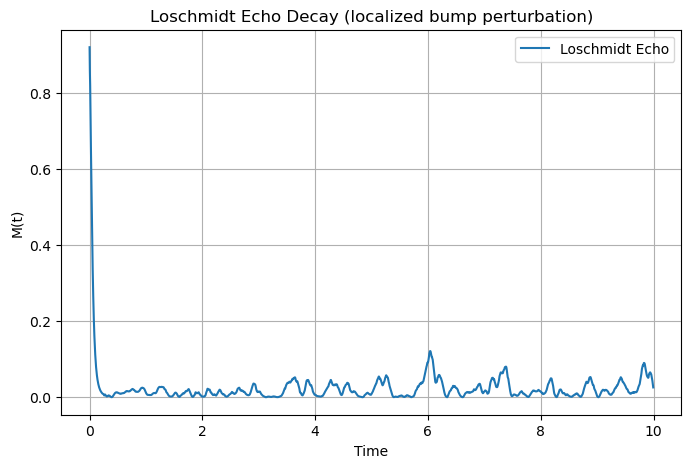

In [ ]:
# Loschmidt echo calculation (localized bump perturbation)
from scipy.sparse import diags
from tqdm import tqdm

# Parameters for the bump
bump_strength = 0.1  # Perturbation strength
bump_sigma = 0.7     # Width of bump
x0_bump = x0         # Use same center as initial wavepacket
y0_bump = y0

# Construct bump potential (restricted to free points)
V_bump = bump_strength * np.exp(-((X - x0_bump)**2 + (Y - y0_bump)**2) / (2 * bump_sigma**2))
V_bump_flat = V_bump.flatten()
V_bump_free = V_bump_flat[free_points]

# Perturbed Hamiltonian: H_pert = H_free + V_bump
H_pert_bump = H_free + diags(V_bump_free, 0)

# Crank-Nicolson matrices for perturbed Hamiltonian
A_pert_bump = (I_free + 1j * dt / (2*hbar) * H_pert_bump).tocsc()
B_pert_bump = (I_free - 1j * dt / (2*hbar) * H_pert_bump).tocsc()
LU_pert_bump = splu(A_pert_bump)

# Loschmidt echo evolution
echo_steps = 2000
psi_bwd = psi_free.copy()
M_t = []

for t in tqdm(range(echo_steps), desc='Loschmidt echo evolution'):
    b_vec = B_pert_bump @ psi_bwd
    psi_bwd = LU_pert_bump.solve(b_vec)
    overlap = np.vdot(psi_free, psi_bwd) * dx * dy
    M_t.append(np.abs(overlap)**2)

# Plot Loschmidt echo
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(8,5))
plt.plot(times_echo, M_t, label='Loschmidt Echo')
plt.xlabel('Time')
plt.ylabel('M(t)')
plt.title('Loschmidt Echo Decay (localized bump perturbation)')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=0.950: 100%|██████████| 5000/5000 [00:06<00:00, 816.41it/s]

Loschmidt echo a=1.020: 100%|██████████| 5000/5000 [00:06<00:00, 813.76it/s]

Loschmidt echo a=1.050: 100%|██████████| 5000/5000 [00:06<00:00, 729.79it/s]

Loschmidt echo a=2.000: 100%|██████████| 5000/5000 [00:10<00:00, 478.65it/s]



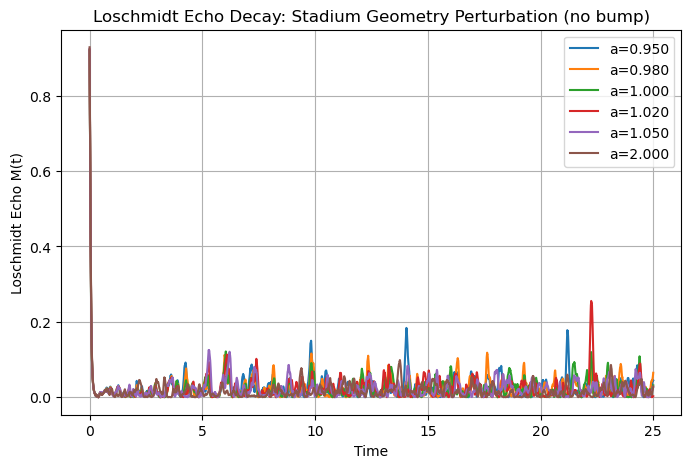

In [ ]:
# Loschmidt echo with only stadium geometry perturbation (varying 'a', no bump)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
echo_steps = 1000
perturbations_a = [a*0.95, a*0.98, a, a*1.02, a*1.05,a*1.1]
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    # Use same Laplacian construction as initial
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(8,5))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium Geometry Perturbation (no bump)')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=1.010: 100%|██████████| 1000/1000 [00:01<00:00, 773.25it/s]

Loschmidt echo a=1.100: 100%|██████████| 1000/1000 [00:01<00:00, 714.49it/s]

Loschmidt echo a=1.500: 100%|██████████| 1000/1000 [00:01<00:00, 550.49it/s]



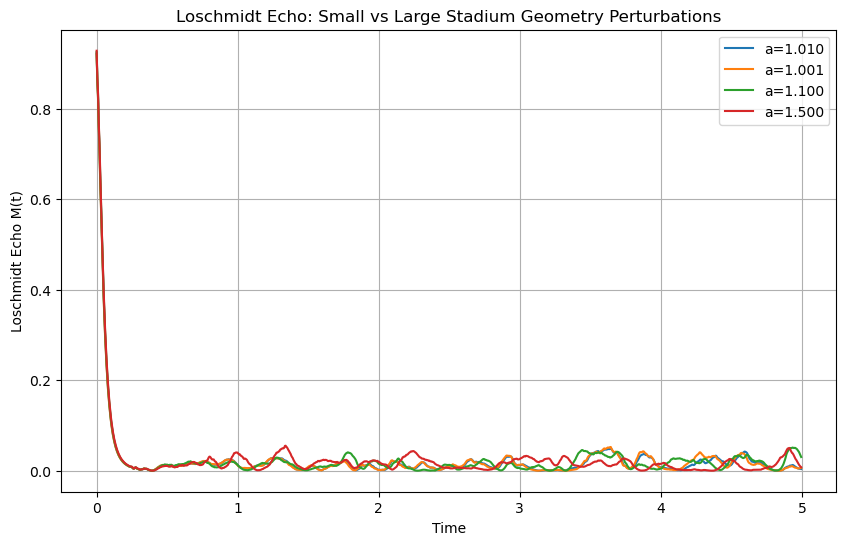

In [ ]:
# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
# Use a range of small and large perturbations
perturbations_a = [a*1.01,a*1.001, a*1.10,a*1.5]
echo_steps = 1000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=1.010: 100%|██████████| 1000/1000 [00:01<00:00, 783.08it/s]

Loschmidt echo a=1.100: 100%|██████████| 1000/1000 [00:01<00:00, 713.00it/s]

Loschmidt echo a=1.500: 100%|██████████| 1000/1000 [00:01<00:00, 587.05it/s]

Loschmidt echo a=2.000: 100%|██████████| 1000/1000 [00:02<00:00, 475.30it/s]

Loschmidt echo a=4.000: 100%|██████████| 1000/1000 [00:03<00:00, 332.56it/s]



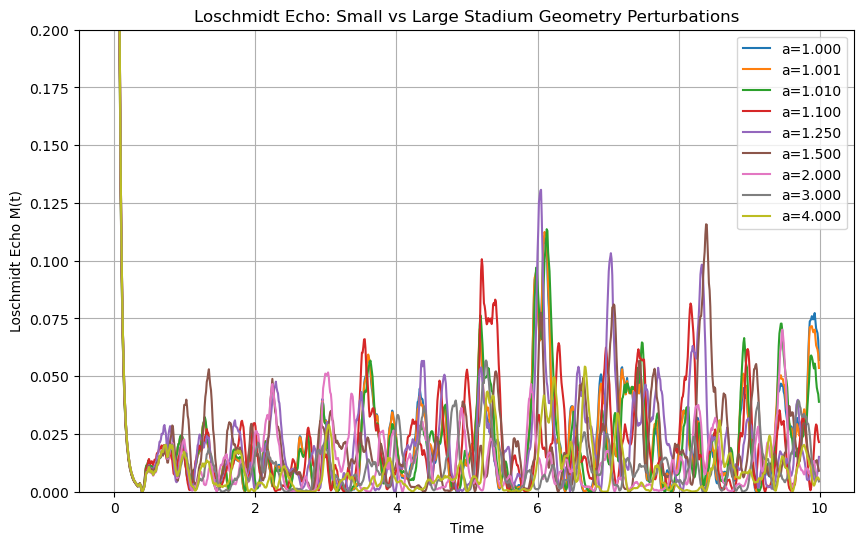

In [ ]:
dt = 0.01  # Decreased time step for finer evolution

# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
perturbations_a = [ a*1.0001,a*1.001,a*1.01,a*1.10, a*1.25,a*1.5, a*2.0, a*3.0,a*4.0]
echo_steps = 1000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt

# Plot Loschmidt echo for all a perturbations with y-axis limited to 0.2
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.ylim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

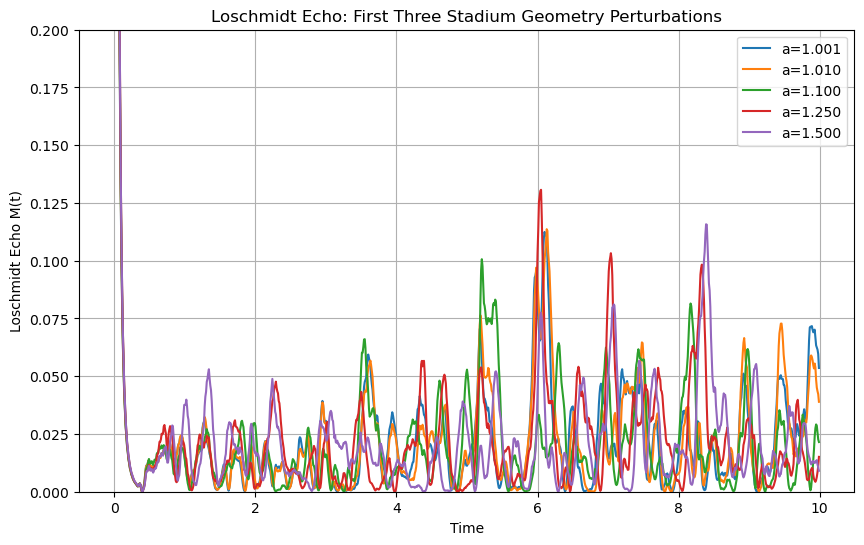

In [ ]:
# Plot Loschmidt echo for only the first three values of a
plt.figure(figsize=(10,6))
for i, (a_p, M_t) in enumerate(echo_results.items()):
    if i>0 and i < 6:
        plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: First Three Stadium Geometry Perturbations')
plt.ylim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()

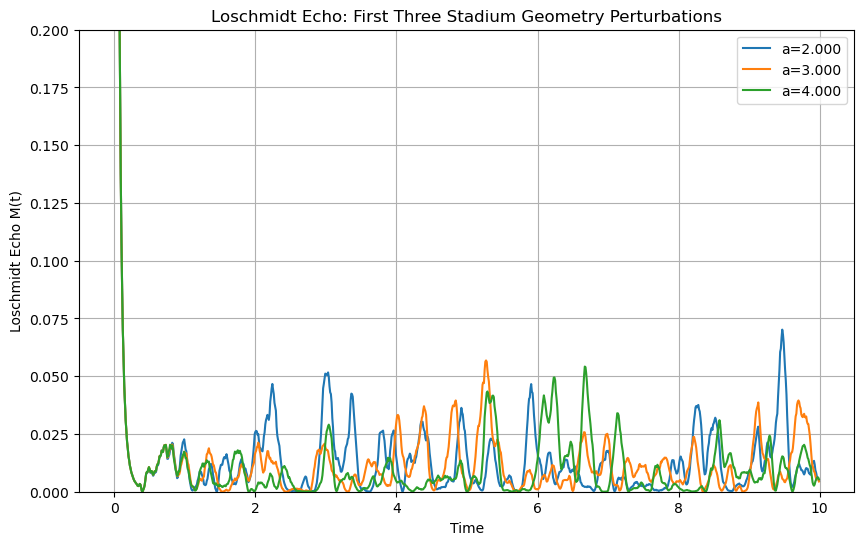

In [ ]:
# Plot Loschmidt echo for only the first three values of a
plt.figure(figsize=(10,6))
for i, (a_p, M_t) in enumerate(echo_results.items()):
    if i >= 5:
        plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: First Three Stadium Geometry Perturbations')
plt.ylim(0, 0.2)
plt.legend()
plt.grid(True)
plt.show()